In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import animation, colors
from IPython.display import HTML
import os
from help_functions import *

In [9]:
class SOM:
    def __init__(self, map_width, map_height, input_dim, neighbourhood_function,
                 distance_k, learning_rate=0.5, sigma=None, decay_type='exponential', beta=0.999):
        self.map_width = map_width
        self.map_height = map_height
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.distance_k = distance_k
        self.beta = beta
        self.time = 1
        self.label_map_db = {}
        self.weights_db = {}
        
        if sigma is None:
            self.sigma = max(map_width, map_height) / 2.0
        else:
            self.sigma = sigma
            
        if self.distance_k == np.inf:
            self.calculate_distance_func = chebyshev_distance
        elif self.distance_k == 1:
            self.calculate_distance_func = manhattan_distance
        elif self.distance_k == 2:
            self.calculate_distance_func = euclidean_distance
        elif self.distance_k < 1:
            raise ValueError('Distance must have positive non-zero k value')
        elif self.distance_k > 2:
            self.calculate_distance_func = lambda a, b, axis: generic_distance(a, b, axis, self.distance_k)
        else:
            raise ValueError('Distance k must be whole number between 1 and np.inf')
            
        # TODO add other weight initialization options
        self.weights = np.random.rand(self.map_width, self.map_height, self.input_dim)
        
        if neighbourhood_function == 'gaussian':
            self.neighbourhood_func = gaussian_neighbourhood
        elif neighbourhood_function == 'rectangular':
            self.neighbourhood_func = rectangular_neighbourhood
        elif neighbourhood_function == 'triangular':
            self.neighbourhood_func = triangular_neighbourhood
        elif neighbourhood_function == 'cosine':
            self.neighbourhood_func = cosine_down_to_zero_neighbourhood
        else:
            raise ValueError(f'Unknown neighbourhood function {neighbourhood_function}')
        
        
        if decay_type == 'exponential' and 0 < self.beta < 1:
            self.calculate_decay = decay_exponential
        elif decay_type == 'power' and self.beta < 0:
            self.calculate_decay = decay_power
        else:
            raise ValueError(f'Unknown decay type or invalid beta')
            
    def get_weights(self):
        return self.weights
    
    def get_weight_of_node(self, node_idx):
        return self.weights[node_idx[0]][node_idx[1]]
    
    def update_time(self):
        self.time += 1
        
    def find_BMU(self, input_vector):
        dists = self.calculate_distance_func(self.weights, input_vector, 2)

        min_index = np.argmin(dists)
        bmu_idx = np.unravel_index(min_index, dists.shape)
        return bmu_idx
    
    def calculate_grid_distances(self, bmu_idx):
        x_coords, y_coords = np.meshgrid(np.arange(self.map_width), 
                                         np.arange(self.map_height), indexing='ij')
        dist_sq = (x_coords - bmu_idx[0])**2 + (y_coords - bmu_idx[1])**2
        return np.sqrt(dist_sq)
            
    def calculate_neighbourhood_influence(self, bmu_idx, sigma_t):
        grid_dists = self.calculate_grid_distances(bmu_idx)
        return self.neighbourhood_func(grid_dists, sigma_t)
    
    def update_weights(self, input_vector, bmu_idx):
        eta_t = self.calculate_decay(self.learning_rate, self.beta, self.time)
        sigma_t = self.calculate_decay(self.sigma, self.beta, self.time)
        
        # shape (map_width, map_height)
        influence = self.calculate_neighbourhood_influence(bmu_idx, sigma_t)
        
        # shape (map_width, map_height, input_dim)
        diff = input_vector - self.weights
        
        # reshaping to (map_width, map_height, 1) to broadcast over diff
        influence_new = influence[:, :, np.newaxis]
        
        self.weights += eta_t * influence_new * diff
        
    def calculate_QE(self, data):
        diff_total = 0
        for sample in data:
            bmu_idx = self.find_BMU(sample)      
            weight = self.get_weight_of_node(bmu_idx)
            
            diff_total += self.calculate_distance_func(weight, sample, 0)
        
        return diff_total / data.shape[0]
    
    
    
    def train_online(self, data, label, num_epochs):
        num_samples = data.shape[0]
        
        for epoch in range(num_epochs):
            for sample in range(num_samples):
                input_vector = data[sample]
                
                bmu_idx = self.find_BMU(input_vector)
                
                self.update_weights(input_vector, bmu_idx)
                
            self.update_time()
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs} complete. Current sigma: {self.calculate_decay(self.sigma, self.beta, self.time):.4f}, learning rate: {self.calculate_decay(self.learning_rate, self.beta, self.time):.4f}, QE: {self.calculate_QE(data):.4f}")
                
            if epoch % 50 == 0:    
                self.weights_db[epoch] = self.weights.copy()
    
    

In [10]:
df = pd.read_csv("../data/iris.csv")
y = df['Iris-setosa']
y_int = y.map({label: i for i, label in enumerate(np.unique(y))})
X = df.drop(['Iris-setosa'], axis=1).to_numpy()
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [11]:
som = SOM(10,10,4,"gaussian",2)

In [12]:
som.train_online(X, y_int, 4000)

Epoch 0/4000 complete. Current sigma: 4.9900, learning rate: 0.4990, QE: 0.5079
Epoch 10/4000 complete. Current sigma: 4.9403, learning rate: 0.4940, QE: 0.5078
Epoch 20/4000 complete. Current sigma: 4.8911, learning rate: 0.4891, QE: 0.5074
Epoch 30/4000 complete. Current sigma: 4.8425, learning rate: 0.4842, QE: 0.5069
Epoch 40/4000 complete. Current sigma: 4.7942, learning rate: 0.4794, QE: 0.5067
Epoch 50/4000 complete. Current sigma: 4.7465, learning rate: 0.4747, QE: 0.5074
Epoch 60/4000 complete. Current sigma: 4.6993, learning rate: 0.4699, QE: 0.5070
Epoch 70/4000 complete. Current sigma: 4.6525, learning rate: 0.4652, QE: 0.5055
Epoch 80/4000 complete. Current sigma: 4.6062, learning rate: 0.4606, QE: 0.5051
Epoch 90/4000 complete. Current sigma: 4.5603, learning rate: 0.4560, QE: 0.5042
Epoch 100/4000 complete. Current sigma: 4.5149, learning rate: 0.4515, QE: 0.5043
Epoch 110/4000 complete. Current sigma: 4.4700, learning rate: 0.4470, QE: 0.5048
Epoch 120/4000 complete. Cu

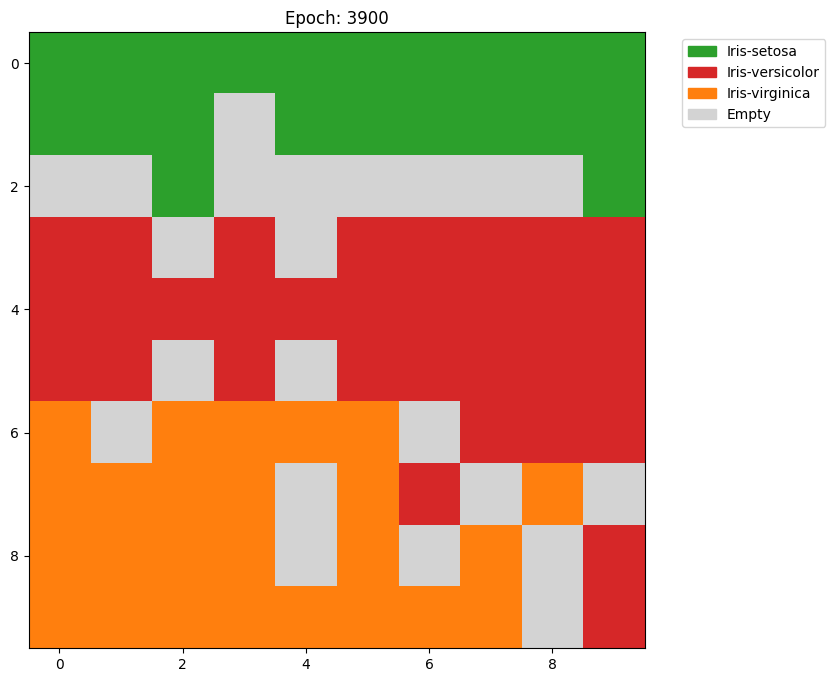

In [13]:
label_matrix_db = generate_label_matrix_db(som, X, y_int)
visualize_label_matrix(label_matrix_db[3900], y, 3900)

In [14]:
video = generate_label_matrix_vid(label_matrix_db, y)
display(video)

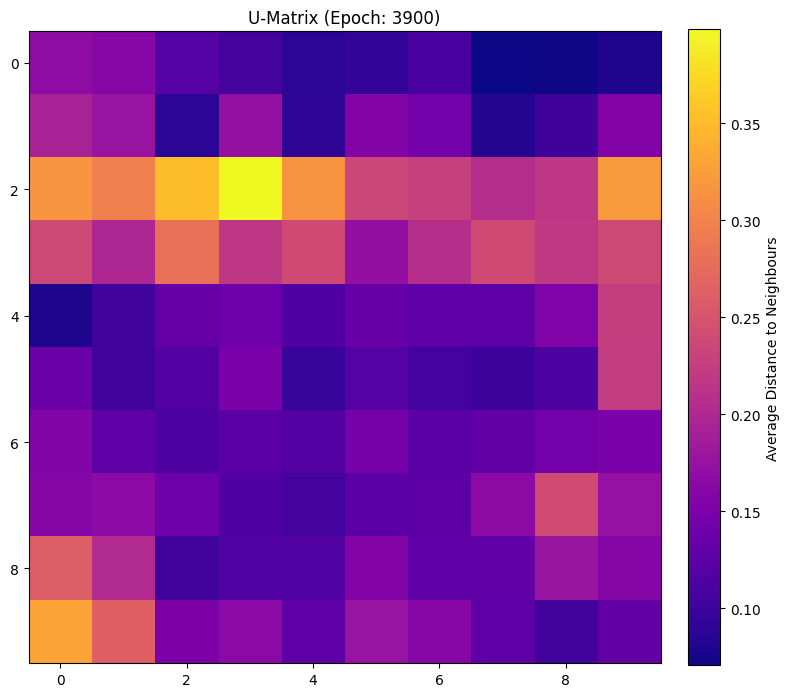

In [15]:
u_matrix_db = generate_u_matrix_db(som)    
visualize_u_matrix(u_matrix_db[3900], 3900)

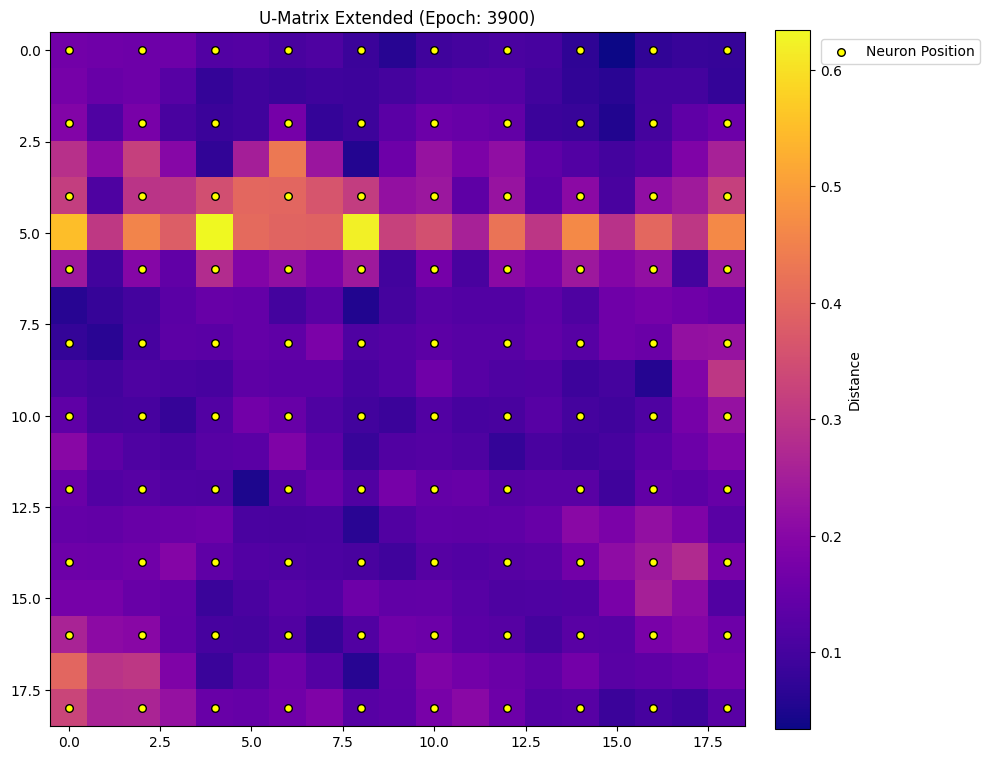

In [16]:
u_matrix_extended_db = generate_u_matrix_extended_db(som)
visualize_u_matrix_extended(u_matrix_extended_db[3900], 3900)

In [10]:
video = generate_u_matrix_vid(u_matrix_db)
display(video)

In [7]:
video = generate_u_matrix_extended_vid(u_matrix_extended_db)
display(video)